# Loading the dataset

In [54]:
import pandas as pd
import numpy as np

Train=np.array(pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv'))[:,1:]
Test=np.array(pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv'))[:,1:]

X_train=np.concatenate([Train,Test]).reshape(-1,28,28)/255
print(X_train.shape)

(70000, 28, 28)


# Generator

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.backend import clear_session

clear_session()

generator = Sequential([
    Dense(7*7*256, use_bias=False,input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7,7,256)),

    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False),
])

generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

# Discriminator

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.backend import clear_session

clear_session()

discriminator = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28,28,1)),
    LeakyReLU(),
    Dropout(0.3),

    Conv2D(128, (5, 5), strides=(1, 1), padding='same',),
    LeakyReLU(),
    Dropout(0.3),

    Flatten(),
    Dense(1,activation='sigmoid')
])

discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,681 (905.00 KB)

 Trainable params: 231,681 (905.00 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
loss=tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output),fake_output)

def discriminator_loss(real_output,fake_output):
    return loss(tf.zeros_like(fake_output),fake_output)+loss(tf.ones_like(real_output),real_output)

Epoch 1/50
Generator Loss: 2.2450, Discriminator Loss: 0.5127


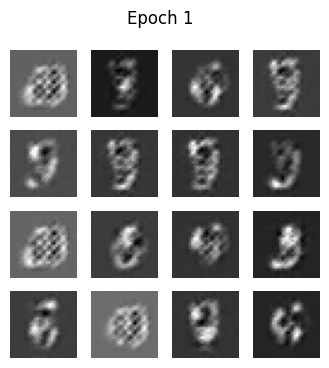

Epoch 2/50
Generator Loss: 2.6246, Discriminator Loss: 0.3702


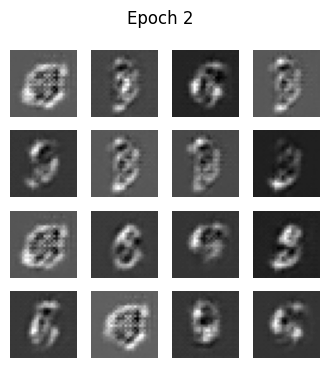

Epoch 3/50
Generator Loss: 2.6813, Discriminator Loss: 0.3546


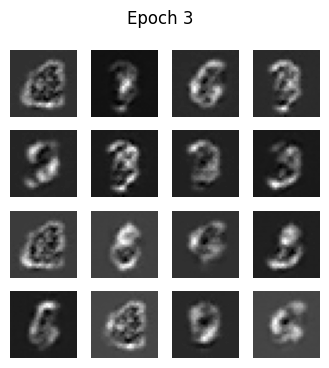

Epoch 4/50
Generator Loss: 2.8303, Discriminator Loss: 0.3887


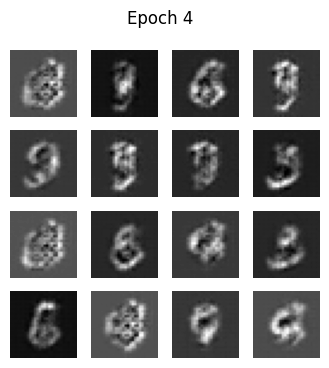

Epoch 5/50
Generator Loss: 2.6565, Discriminator Loss: 0.3285


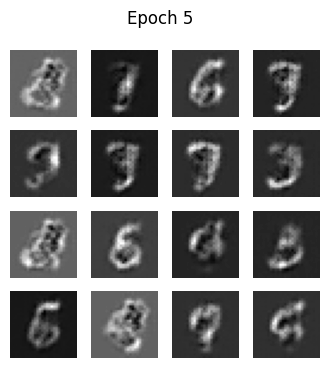

Epoch 6/50
Generator Loss: 3.5398, Discriminator Loss: 0.2776


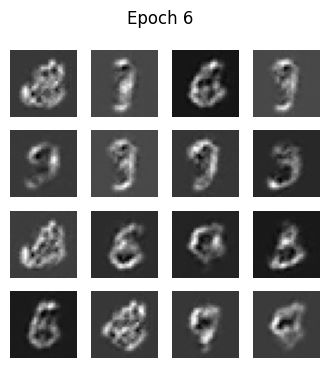

Epoch 7/50
Generator Loss: 3.1209, Discriminator Loss: 0.3168


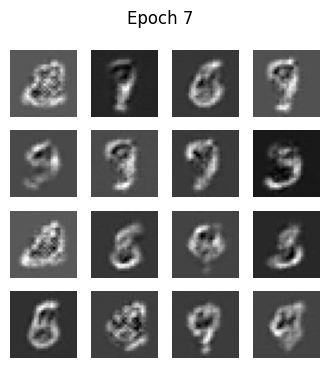

Epoch 8/50
Generator Loss: 2.4844, Discriminator Loss: 0.4079


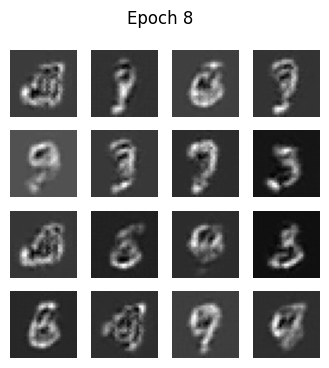

Epoch 9/50
Generator Loss: 2.2057, Discriminator Loss: 0.5315


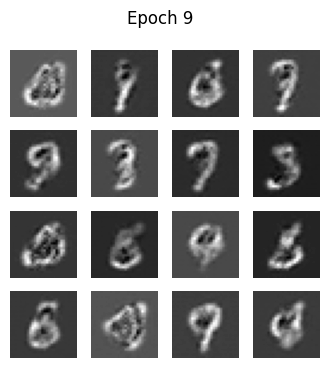

Epoch 10/50
Generator Loss: 2.9390, Discriminator Loss: 0.3664


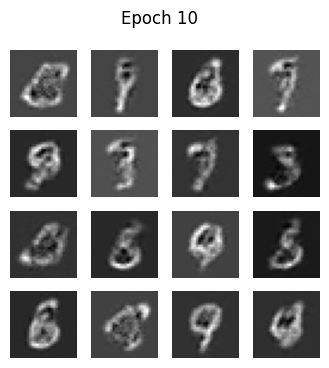

Epoch 11/50
Generator Loss: 3.2009, Discriminator Loss: 0.3089


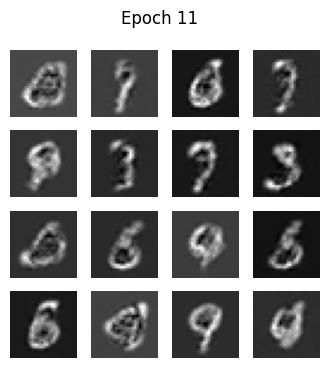

Epoch 12/50
Generator Loss: 2.7569, Discriminator Loss: 0.3859


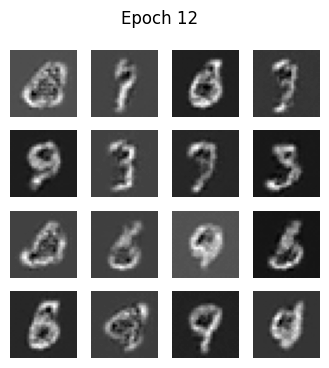

Epoch 13/50
Generator Loss: 3.1344, Discriminator Loss: 0.3051


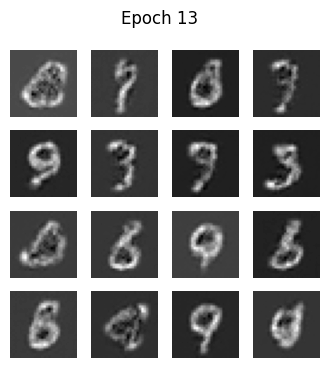

Epoch 14/50
Generator Loss: 2.9450, Discriminator Loss: 0.3354


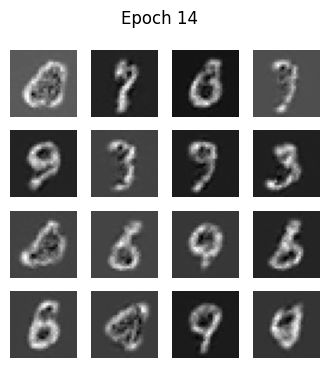

Epoch 15/50
Generator Loss: 2.7277, Discriminator Loss: 0.2919


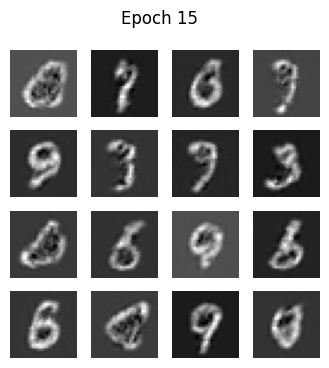

Epoch 16/50
Generator Loss: 2.6803, Discriminator Loss: 0.3193


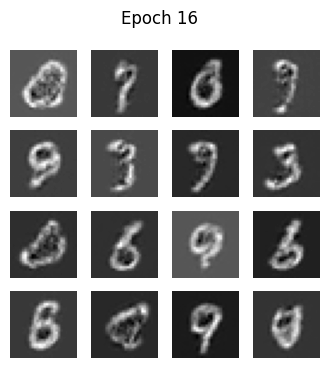

Epoch 17/50
Generator Loss: 3.0935, Discriminator Loss: 0.3331


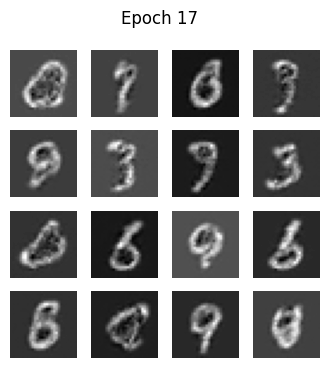

Epoch 18/50
Generator Loss: 2.8721, Discriminator Loss: 0.4255


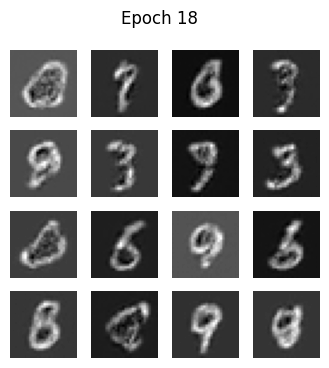

Epoch 19/50
Generator Loss: 2.9643, Discriminator Loss: 0.3840


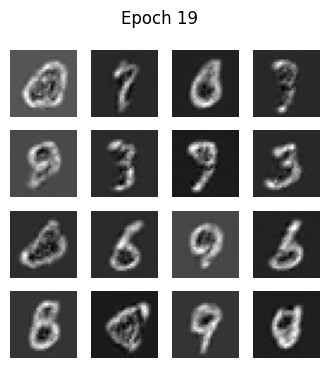

Epoch 20/50
Generator Loss: 2.8592, Discriminator Loss: 0.3527


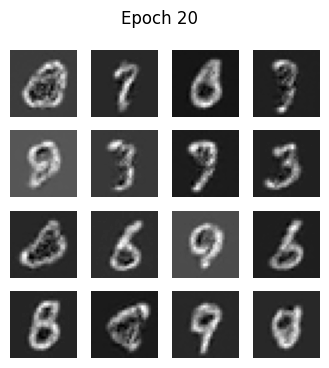

Epoch 21/50
Generator Loss: 2.9522, Discriminator Loss: 0.3299


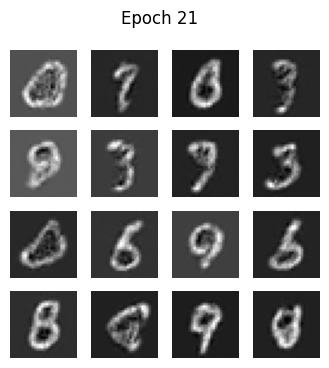

Epoch 22/50
Generator Loss: 2.9399, Discriminator Loss: 0.3724


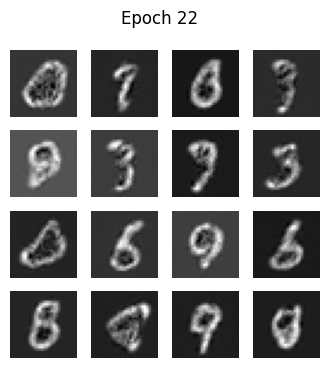

Epoch 23/50
Generator Loss: 3.2147, Discriminator Loss: 0.2749


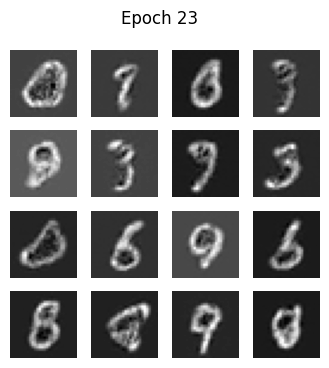

Epoch 24/50
Generator Loss: 2.6223, Discriminator Loss: 0.3214


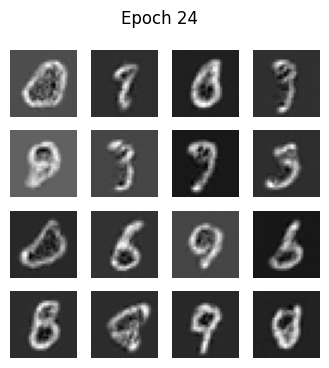

Epoch 25/50
Generator Loss: 3.1044, Discriminator Loss: 0.3153


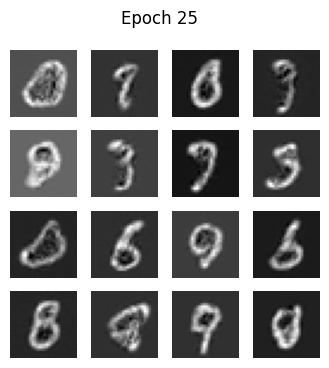

Epoch 26/50
Generator Loss: 3.6282, Discriminator Loss: 0.2629


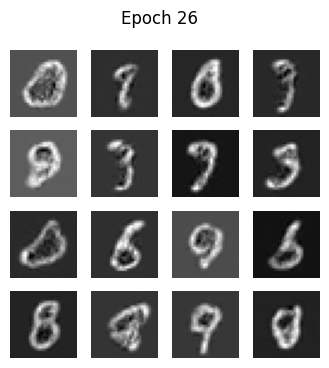

Epoch 27/50
Generator Loss: 2.9614, Discriminator Loss: 0.3764


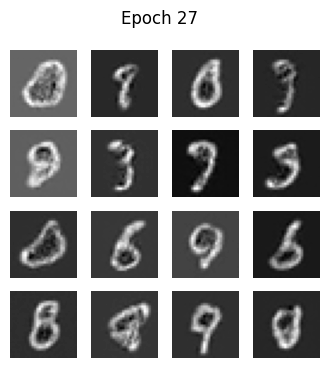

Epoch 28/50
Generator Loss: 2.9368, Discriminator Loss: 0.2708


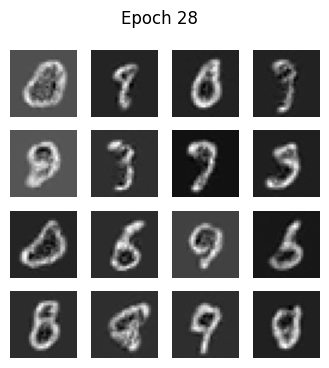

Epoch 29/50
Generator Loss: 3.1766, Discriminator Loss: 0.3347


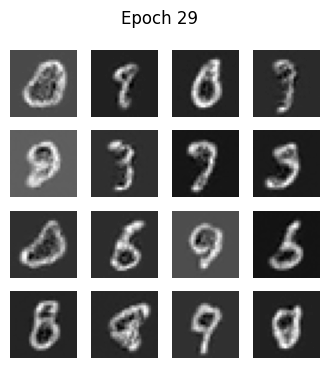

Epoch 30/50
Generator Loss: 3.1828, Discriminator Loss: 0.2725


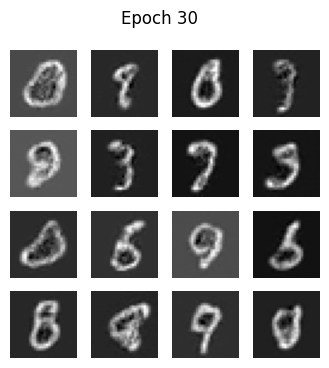

Epoch 31/50
Generator Loss: 3.7739, Discriminator Loss: 0.1993


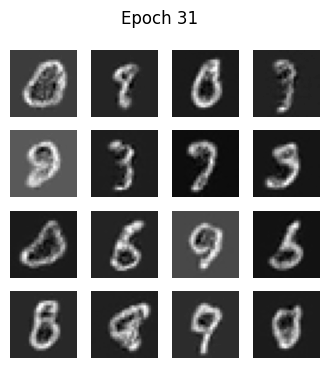

Epoch 32/50
Generator Loss: 3.2538, Discriminator Loss: 0.3502


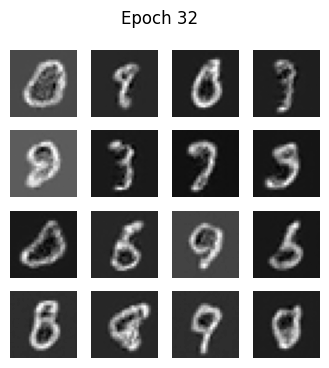

Epoch 33/50
Generator Loss: 3.0723, Discriminator Loss: 0.2443


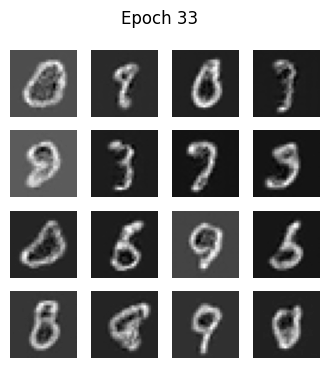

Epoch 34/50
Generator Loss: 3.3030, Discriminator Loss: 0.2963


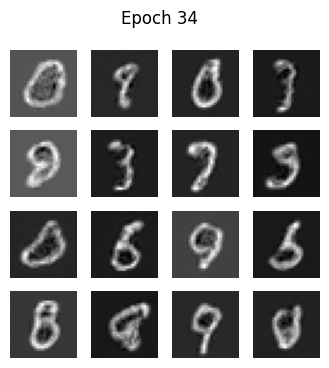

Epoch 35/50
Generator Loss: 3.8479, Discriminator Loss: 0.3130


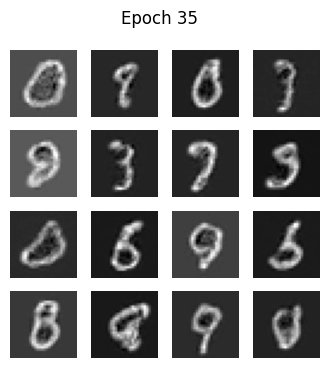

Epoch 36/50
Generator Loss: 3.9622, Discriminator Loss: 0.2083


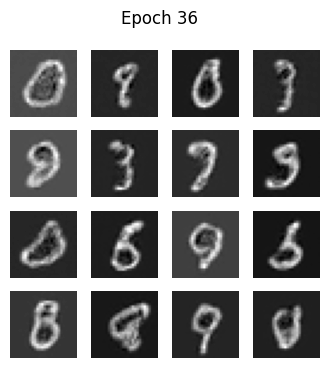

Epoch 37/50
Generator Loss: 3.6743, Discriminator Loss: 0.2495


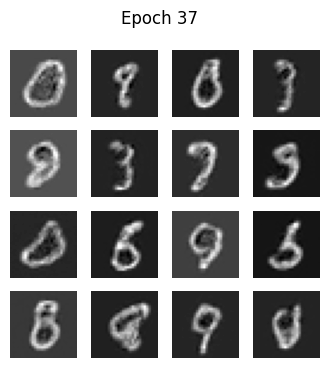

Epoch 38/50
Generator Loss: 3.4172, Discriminator Loss: 0.2008


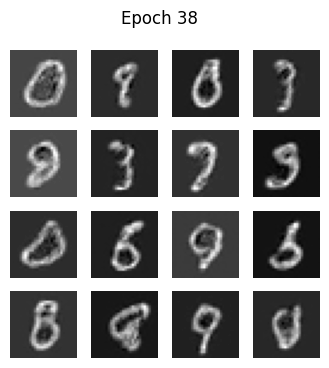

Epoch 39/50
Generator Loss: 3.2385, Discriminator Loss: 0.2239


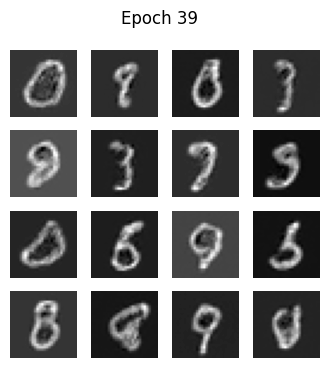

Epoch 40/50
Generator Loss: 3.4779, Discriminator Loss: 0.3027


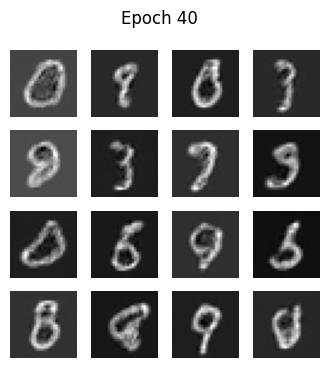

Epoch 41/50
Generator Loss: 3.6957, Discriminator Loss: 0.2610


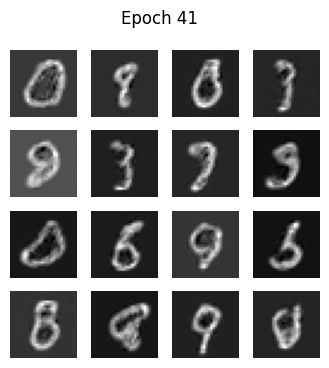

Epoch 42/50
Generator Loss: 3.1344, Discriminator Loss: 0.1974


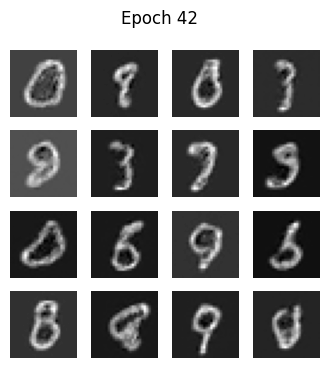

Epoch 43/50
Generator Loss: 4.1023, Discriminator Loss: 0.1860


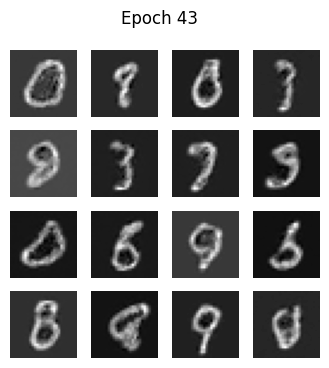

Epoch 44/50
Generator Loss: 4.1305, Discriminator Loss: 0.2481


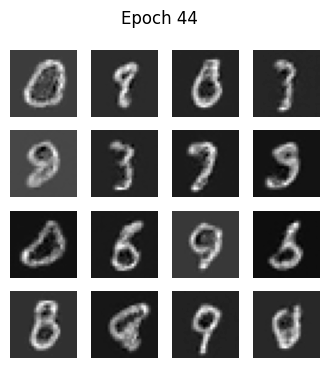

Epoch 45/50
Generator Loss: 3.7027, Discriminator Loss: 0.2104


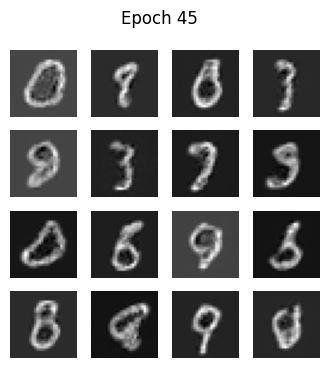

Epoch 46/50
Generator Loss: 3.8216, Discriminator Loss: 0.3018


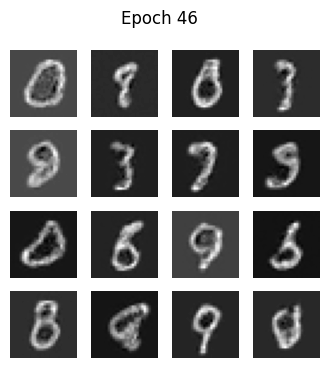

Epoch 47/50
Generator Loss: 3.5624, Discriminator Loss: 0.1605


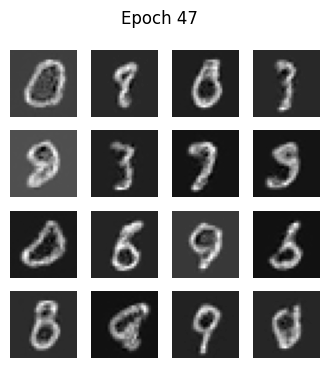

Epoch 48/50
Generator Loss: 3.8664, Discriminator Loss: 0.2562


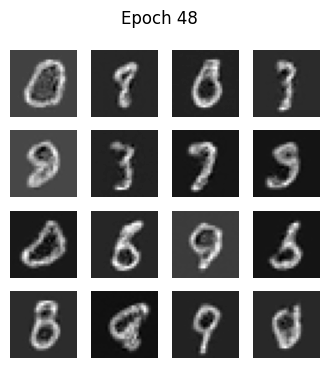

Epoch 49/50
Generator Loss: 3.2984, Discriminator Loss: 0.2191


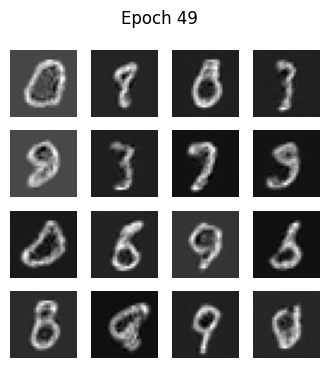

Epoch 50/50
Generator Loss: 3.8255, Discriminator Loss: 0.2201


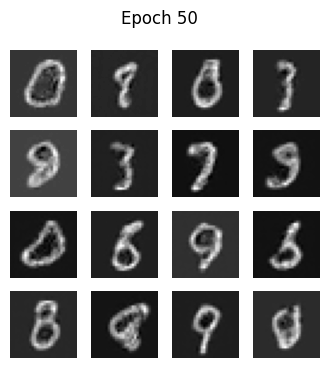

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Hyperparameters
noise_dim = 100
batch_size = 256
epochs = 50
seed = tf.random.normal([16, noise_dim])  

# Optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    # Train discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss

# Visualization function
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()
    plt.close(fig)

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")
        generate_and_save_images(generator, epoch + 1, seed)

# Prepare dataset
buffer_size = X_train.shape[0]
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

# Train the GAN
train(dataset, epochs)